In [1]:
import pandas as pd
import sys
sys.path.append('/home/ifenty/git_repos_others/ECCO-GROUP/ECCOv4-py')
import ecco_v4_py as ecco
import matplotlib as mpl

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path

import matplotlib.pyplot as plt
import json
import time

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import warnings
warnings.filterwarnings('ignore')
import dask
dask.config.set({'temporary_directory': '/mnt/intraid/ian1/ifenty/dask_tmp'})

# Works on Ian's Machine, but not necessary
from dask.distributed import Client, progress
#client = Client(processes=False, threads_per_worker=48)
client = Client(processes=False, n_workers=1, threads_per_worker=8,memory_limit='128GB')
client

Client Scheduler: inproc://137.78.251.47/93088/1 Dashboard: http://137.78.251.47:8787/status,Cluster Workers: 1 Cores: 8 Memory: 128.00 GB


# Ocean Heat Content
q[J] = T[K] ocean_cp [J kg-1 K-1] rho [kg m-3] v [m3]

Ocean Heat Capacity:

In [2]:
ocean_cp = 3992 #J/kg/K

In [3]:
def load_ecco_fields(data_dir, basename):
    time_start=time.time()

    # opening 312 monthly mean files takes about 40s using parallel & dask
    glob_name = basename + '*nc'
    ecco_files = list(data_dir.glob(glob_name))
    ocean_TS = xr.open_mfdataset(ecco_files, parallel=True, data_vars='minimal',\
                                  coords='minimal',compat='override')
    
    tt = time.time() - time_start    
    print(tt / len(ecco_files))
    print(time.time() - time_start)
    return ocean_TS

## Native Grid

In [5]:
grid_dir = Path('/home/ifenty/data/grids/grid_ECCOV4r4')

## load the native grid file
ecco_grid = xr.open_dataset(grid_dir / 'GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc').load()
ecco_grid.title

'ECCO Geometry Parameters for the Lat-Lon-Cap 90 (llc90) Native Model Grid (Version 4 Release 4)'

In [6]:
root_dir = Path('/home/ifenty/ian1/ifenty/ECCOv4/Version4/Release4/podaac')

# define directories with V4r4 files on native grid
density_dir =  root_dir / 'native/mon_mean/OCEAN_DENS_STRAT_PRESS'
ocean_TS_dir = root_dir / 'native/mon_mean/OCEAN_TEMPERATURE_SALINITY'

In [7]:
ocean_TS = load_ecco_fields(ocean_TS_dir,'OCEAN')
ocean_density = load_ecco_fields(density_dir,'OCEAN')

0.15840948392183352
49.425180435180664
0.19086906390312391
59.551411628723145


In [8]:
# combine the variables with the grid dataset
ecco_mon_native = ecco_grid.combine_first(xr.merge([ocean_TS, ocean_density]))

In [9]:
print(list(ecco_mon_native.data_vars))

['CS', 'SN', 'rA', 'dxG', 'dyG', 'Depth', 'rAz', 'dxC', 'dyC', 'rAw', 'rAs', 'drC', 'drF', 'PHrefC', 'PHrefF', 'hFacC', 'hFacW', 'hFacS', 'maskC', 'maskW', 'maskS', 'THETA', 'SALT', 'RHOAnoma', 'DRHODR', 'PHIHYD', 'PHIHYDcR']


In [10]:
# convert to rho from rho anomaly
rho = ecco_mon_native.RHOAnoma + 1029 #[kg m-3]

In [11]:
#calculate ocean volume
vol = ecco_grid.rA * ecco_grid.drF
total_volume = vol.sum()
print(f'total ocean volume {total_volume.values} m^3')

total ocean volume 3.128007776685523e+18 m^3


In [18]:
k_700m = 24
ecco_grid.Zu[k_700m]

<xarray.DataArray 'Zu' ()>
array(-677.31, dtype=float32)
Coordinates:
    k_u      int32 24
    Zu       float32 -677.3
Attributes:
    long_name:              depth of bottom face of tracer grid cell
    units:                  m
    positive:               up
    comment:                First element is -10m, the depth of the bottom fa...
    coverage_content_type:  coordinate
    standard_name:          depth

In [26]:
k_2000m = 36
ecco_grid.Zu[k_2000m]

<xarray.DataArray 'Zu' ()>
array(-1993.62, dtype=float32)
Coordinates:
    k_u      int32 36
    Zu       float32 -1.994e+03
Attributes:
    long_name:              depth of bottom face of tracer grid cell
    units:                  m
    positive:               up
    comment:                First element is -10m, the depth of the bottom fa...
    coverage_content_type:  coordinate
    standard_name:          depth

In [36]:
#calculate ocean volume
vol = ecco_grid.rA * ecco_grid.drF
vol_700m = vol.isel(k=range(k_700m + 1))
vol_2000m = vol.isel(k=range(k_2000m + 1))

total_volume = vol.sum()
print(f'total ocean volume {total_volume.values} m^3')

total ocean volume 3.128007776685523e+18 m^3


In [218]:
mask_lat = []
for lat_i in range(9):
    lat_min = lat_i * 10
    lat_max = (lat_i + 1)*10
    print(lat_min, lat_max)
    A  = np.where(np.abs(ecco_grid.YC) <  lat_max,1,np.nan)
    B  = np.where(np.abs(ecco_grid.YC) >= lat_min,1,np.nan)
    C = A*B
    mask_lat.append(C)

0 10
10 20
20 30
30 40
40 50
50 60
60 70
70 80
80 90


In [220]:
mask_lat_arr = np.array(mask_lat)

In [32]:
total_volume_700m = vol.isel(k=range(k_700m + 1)).sum()
total_volume_2000m = vol.isel(k=range(k_2000m + 1)).sum()

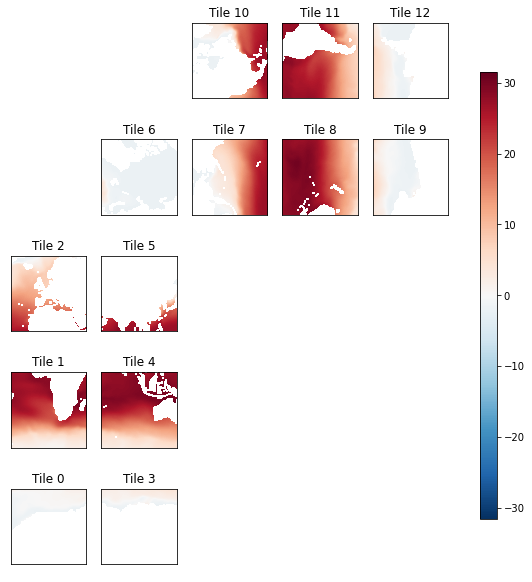

In [277]:
# show snapshot of SST
ecco.plot_tiles(ecco_mon_native.THETA[0,0,:], show_colorbar=True);

In [172]:
mask_lat_DA = xr.DataArray(mask_lat_arr, dims=['lat_i','tile','j','i'])
mask_lat_DA

<xarray.DataArray (lat_i: 9, tile: 13, j: 90, i: 90)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [ 1.,  1.,  1., ...,  1.,  1.,  1.],
         [ 1.,  1.,  1., ...,  1.,  1.,  1.],
         [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ...,  1.,  1.,  1.],
         [nan, nan, nan, ...,  1.,  1.,  1.],
         [nan, nan, nan, ...,  1.,  1.,  1.],
         ...,
         [nan, nan, nan, ...,  1.,  1.,  1.],
         [nan, nan, nan, ...,  1.,  1.,  1.],
         [nan, nan, nan, ...,  1.,  1.,  1.]]]])
Dimensions without coordinates: lat_i, tile, j, i

In [222]:
# q is ocean heat content
start_time = time.time()

q = (ecco_mon_native.THETA * (ecco_mon_native.RHOAnoma + 1029) * vol * ocean_cp).compute()

print(time.time() - start_time)

77.07862591743469


In [223]:
qs_h = q.sum(dim=['tile','j','i'])

In [224]:
qs_h_lat = []
for i in range(9):
    start_time = time.time()
    tmp = q * mask_lat_DA.isel(lat_i = i)
    tmp_qs = tmp.sum(dim=['tile','j','i'])
    qs_h_lat.append(tmp_qs)
    print(i, time.time() - start_time)


0 25.423855304718018
1 31.90348744392395
2 28.381788969039917
3 26.51790952682495
4 28.615672826766968
5 33.86277723312378
6 29.005268096923828
7 30.040456771850586
8 25.54592990875244


In [230]:
qs = qs_h.sum(dim = 'k')
qs_700m = qs_h.isel(k=range(k_700m + 1)).sum(dim = 'k')
qs_2000m = qs_h.isel(k=range(k_2000m + 1)).sum(dim = 'k')

In [303]:
qs_ZJ = (qs - qs.mean())/  1e21
qs_ZJ_700m = (qs_700m - qs_700m.mean())/  1e21
qs_ZJ_2000m = (qs_2000m - qs_2000m.mean())/  1e21

In [320]:
qs_lat_list = []
qs_lat_700m_list = []
qs_lat_2000m_list = []

for i in range(9):
    qs_lat_list.append(qs_h_lat[i].sum(dim='k'))
    qs_lat_700m_list.append(qs_h_lat[i].isel(k=range(k_700m + 1)).sum(dim = 'k'))
    qs_lat_2000m_list.append(qs_h_lat[i].isel(k=range(k_2000m + 1)).sum(dim = 'k'))

In [323]:
qs_lat_arr = np.array(qs_lat_list)
qs_lat_700m_arr = np.array(qs_lat_700m_list)
qs_lat_2000m_arr = np.array(qs_lat_2000m_list)

In [324]:
qs_lat = xr.DataArray(qs_lat_arr, dims=['lat_i', 'time'], coords={'time':qs.time})
qs_lat_700m = xr.DataArray(qs_lat_700m_arr, dims=['lat_i', 'time'], coords={'time':qs.time})
qs_lat_2000m = xr.DataArray(qs_lat_2000m_arr, dims=['lat_i', 'time'], coords={'time':qs.time})

In [325]:
qs_lat_ZJ = (qs_lat - qs_lat.mean('time'))/1e21
qs_lat_ZJ_700m = (qs_lat_700m - qs_lat_700m_DA.mean('time'))/1e21
qs_lat_ZJ_2000m = (qs_lat_2000m - qs_lat_2000m_DA.mean('time'))/1e21

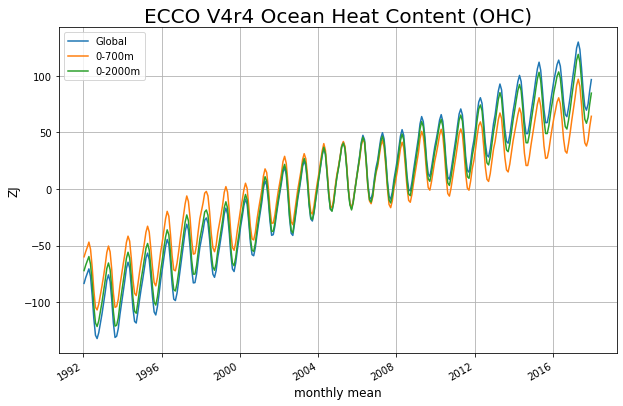

In [326]:
# plot q anomaly [0-700m]
fig = plt.figure(figsize=[10,6]);

# convert OHC to zetajoules and subtract time-mean
qs_ZJ.plot();
qs_ZJ_700m.plot();
qs_ZJ_2000m.plot();
plt.grid()
plt.title('ECCO V4r4 Ocean Heat Content (OHC)', fontsize=20);
plt.ylabel('ZJ', fontsize=12);
plt.xlabel('monthly mean', fontsize=12);
plt.legend(['Global','0-700m','0-2000m'])

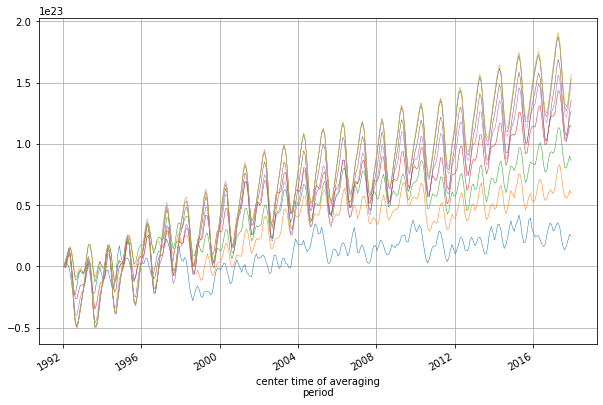

In [316]:
fig = plt.figure(figsize=[10,6]);

tmp = qs_lat_2000m_DA.cumsum(dim='lat_i')
for i in range(9):
    b = tmp.isel(lat_i = i)
    (b-b[0]).plot(linewidth=.5
    plt.grid()

Text(0.5, 1.0, 'ECCO V4r4 Global Ocean Heat Content Anomaly \nRelative to 1992-2018 mean')

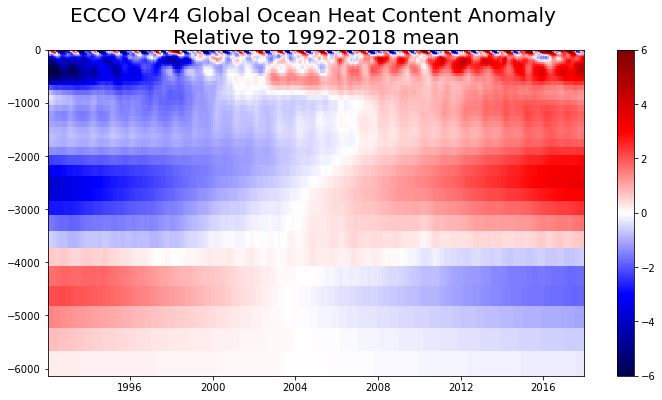

In [295]:
plt.figure(figsize=[12,6]);
tmp = (qs_h -qs_h.mean(dim='time')).T / 1e21
plt.pcolormesh(qs.time, ecco_grid.Zp1, tmp, cmap='seismic',vmin=-6, vmax=6);
plt.colorbar()
plt.title('ECCO V4r4 Global Ocean Heat Content Anomaly \nRelative to 1992-2018 mean',fontsize=20)

Text(0.5, 1.0, 'ECCO V4r4 Global Ocean Heat Content Anomaly \nRelative to Jan 1992 (ZJ)')

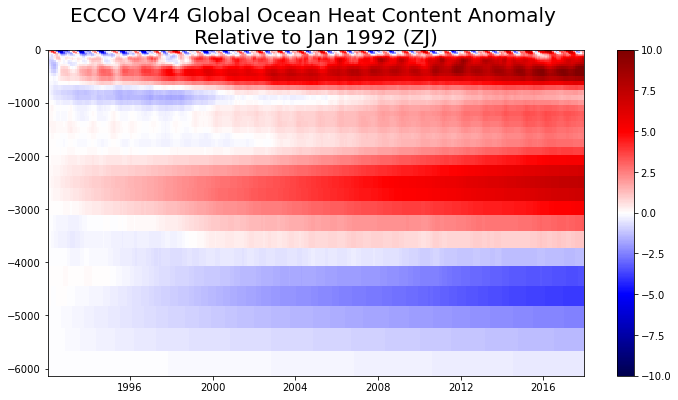

In [297]:
plt.figure(figsize=[12,6]);
tmp = (qs_h -qs_h.isel(time=0)).T / 1e21
plt.pcolormesh(qs.time, ecco_grid.Zp1, tmp, cmap='seismic',vmin=-10, vmax=10);
plt.colorbar()
plt.title('ECCO V4r4 Global Ocean Heat Content Anomaly \nRelative to Jan 1992 (ZJ)',fontsize=20)

Text(0.5, 1.0, 'ECCO V4r4 Global Ocean Heat Content Anomaly \nRelative to Jan 1992 (ZJ)')

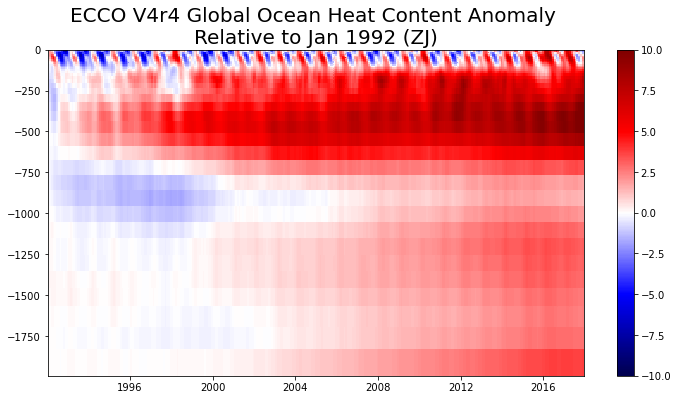

In [299]:
plt.figure(figsize=[12,6]);
tmp = (qs_h -qs_h.isel(time=0)).T / 1e21
plt.pcolormesh(qs.time, ecco_grid.Zp1.isel(k_p1=range(38)), tmp.isel(k=range(37)), cmap='seismic',
               vmin=-10, vmax=10);
plt.colorbar()
plt.title('ECCO V4r4 Global Ocean Heat Content Anomaly \nRelative to Jan 1992 (ZJ)',fontsize=20)

## Zero reference to first record: Jan 1992

In [327]:
# reference with respect to first record
qs_ZJ_zero_ref = qs_ZJ - qs_ZJ[0]
qs_ZJ_700m_zero_ref = qs_ZJ_700m - qs_ZJ_700m[0]
qs_ZJ_2000m_zero_ref = qs_ZJ_2000m - qs_ZJ_2000m[0]


In [328]:
qs_lat_ZJ_zero_ref = qs_lat_ZJ - qs_lat_ZJ.isel(time=0)
qs_lat_ZJ_700m_zero_ref = qs_lat_ZJ_700m - qs_lat_ZJ_700m.isel(time=0)
qs_lat_ZJ_2000m_zero_ref = qs_lat_ZJ_2000m - qs_lat_ZJ_2000m.isel(time=0)

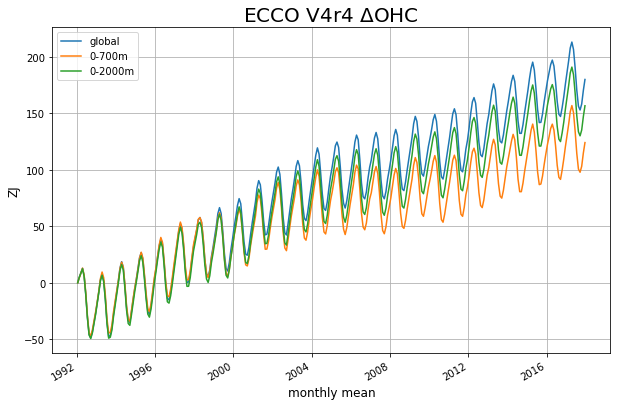

In [330]:
# plot time series
fig = plt.figure(figsize=[10,6]);
qs_ZJ_zero_ref.plot()
qs_ZJ_700m_zero_ref.plot()
qs_ZJ_2000m_zero_ref.plot()

plt.grid()
plt.title('ECCO V4r4 $\Delta$OHC',fontsize=20);
plt.ylabel('ZJ', fontsize=12);
plt.xlabel('monthly mean', fontsize=12);
plt.legend(['global','0-700m','0-2000m'])

## Remove the OHC monthly climatology

In [108]:
# Calculate monthly climatology
qs_ZJ_monthly_climatology = qs_ZJ.groupby('time.month').mean();
qs_ZJ_700m_monthly_climatology = qs_ZJ_700m.groupby('time.month').mean();
qs_ZJ_2000m_monthly_climatology = qs_ZJ_2000m.groupby('time.month').mean();

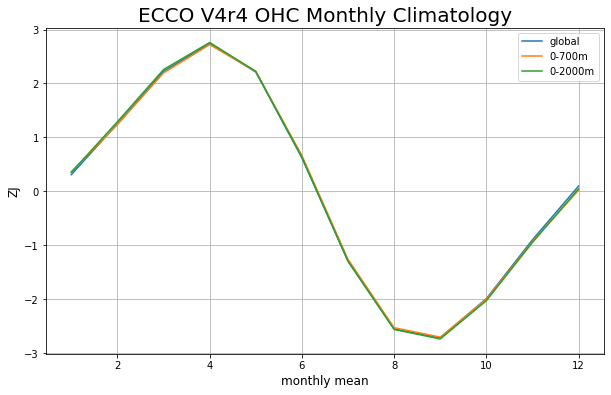

In [118]:
# plot
fig = plt.figure(figsize=[10,6]);
qs_ZJ_monthly_climatology.plot();
qs_ZJ_700m_monthly_climatology.plot();
qs_ZJ_2000m_monthly_climatology.plot();

plt.grid()
plt.title('ECCO V4r4 OHC Monthly Climatology', fontsize=20);
plt.ylabel('ZJ', fontsize=12);
plt.legend(['global','0-700m','0-2000m'])
plt.xlabel('monthly mean', fontsize=12);

In [112]:
#subtract the monthly climatology
qs_ZJ_anom = qs_ZJ.groupby('time.month') - qs_ZJ_monthly_climatology
qs_ZJ_700m_anom = qs_ZJ_700m.groupby('time.month') - qs_ZJ_700m_monthly_climatology
qs_ZJ_2000m_anom = qs_ZJ_2000m.groupby('time.month') - qs_ZJ_2000m_monthly_climatology

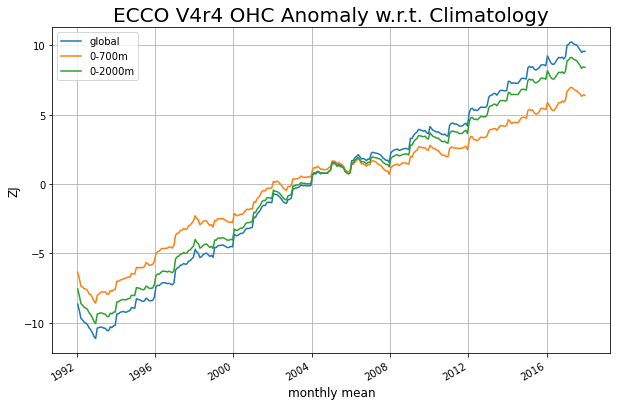

In [119]:
# plot q anomaly
fig = plt.figure(figsize=[10,6]);
qs_ZJ_anom.plot()
qs_ZJ_700m_anom.plot()
qs_ZJ_2000m_anom.plot()

plt.grid()
plt.title('ECCO V4r4 OHC Anomaly w.r.t. Climatology',fontsize=20);
plt.ylabel('ZJ', fontsize=12);
plt.legend(['global','0-700m','0-2000m'])
plt.xlabel('monthly mean', fontsize=12);

## Zero reference to first record: Jan 1992

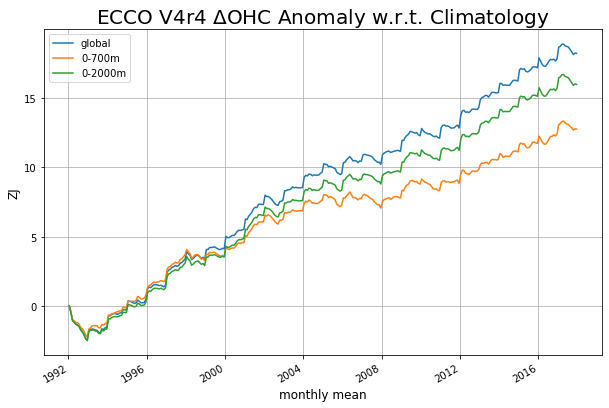

In [120]:
# reference with respect to first record
qs_ZJ_zero_ref_anom = qs_ZJ_anom - qs_ZJ_anom[0]
qs_ZJ_700m_zero_ref_anom = qs_ZJ_700m_anom - qs_ZJ_700m_anom[0]
qs_ZJ_2000m_zero_ref_anom = qs_ZJ_2000m_anom - qs_ZJ_2000m_anom[0]

# plot delta 
fig = plt.figure(figsize=[10,6]);
qs_ZJ_zero_ref_anom.plot()
qs_ZJ_700m_zero_ref_anom.plot()
qs_ZJ_2000m_zero_ref_anom.plot()
plt.grid()
plt.title('ECCO V4r4 $\Delta$OHC Anomaly w.r.t. Climatology',fontsize=20);
plt.ylabel('ZJ', fontsize=12);
plt.xlabel('monthly mean', fontsize=12);
plt.legend(['global','0-700m','0-2000m'])

# Lat-Lon Grid

In [122]:
grid_dir = Path('/home/ifenty/data/grids/grid_ECCOV4r4')

## load the grid
ecco_grid_ll = xr.open_dataset(grid_dir / 'GRID_GEOMETRY_ECCO_v4r4_latlon_0p50deg.nc').load()
ecco_grid_ll.title

'TBD_DATASET'

In [115]:
density_dir = Path('/home/ifenty/ian1/ifenty/ECCOv4/Version4/Release4/podaac/latlon/mon_mean/OCEAN_DENS_STRAT_PRESS')
ocean_TS_dir = Path('/home/ifenty/ian1/ifenty/ECCOv4/Version4/Release4/podaac/latlon/mon_mean/OCEAN_TEMPERATURE_SALINITY')

In [116]:
ocean_TS_ll = load_ecco_fields(ocean_TS_dir,'OCEAN')
ocean_density_ll = load_ecco_fields(density_dir,'OCEAN')

0.09257228252215263
28.882679224014282
0.0949928309672918
29.63813805580139


In [117]:
# merge the vol_fluxes DataSet with the ecco_grid DataSet.
ecco_data_mon_mean_ll=ecco_grid_ll.combine_first(ocean_density_ll)
ecco_data_mon_mean_ll=ecco_data_mon_mean_ll.combine_first(ocean_TS_ll)

In [119]:
# convert to rho from rho anomaly
rho_ll = ecco_data_mon_mean_ll.RHOAnoma + 1029 #[kg m-3]

In [123]:
ecco_grid_ll

<xarray.Dataset>
Dimensions:    (Z: 50, Zp1: 51, latitude: 360, longitude: 720)
Coordinates:
  * Z          (Z) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * Zp1        (Zp1) float32 0.0 -10.0 -20.0 -30.0 ... -5244.5 -5678.0 -6134.5
Data variables:
    hFacC      (Z, latitude, longitude) float64 nan nan nan nan ... nan nan nan
    Depth      (latitude, longitude) float64 nan nan nan ... 4.178e+03 4.178e+03
    area       (latitude, longitude) float64 1.349e+07 1.349e+07 ... 1.349e+07
    drF        (Z) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    drC        (Zp1) float32 5.0 10.0 10.0 10.0 ... 399.0 422.0 445.0 228.25
Attributes:
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    creator_institution:             NASA Jet Propulsion Laboratory (JPL)
    creator_name:                    ECCO Consortium
    creator_type:                    group
    creator_url:                     https://ecco-group.org
    date_created:                    TBD_DATASET
    date_issued:                     TBD_DATASET
    date_metadata_modified:          TBD_DATASET
    geospatial_lat_max:              90.0
    geospatial_lat_min:              -90.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              180.0
    geospatial_lon_min:              -180.0
    geospatial_lon_units:            degrees_east
    geospatial_bounds_crs:           EPSG:4326
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         -6134.5
    geospatial_vertical_positive:    up
    geospatial_vertical_resolution:  variable
    geospatial_vertical_units:       meter
    history:                         Inaugural release of an ECCO Central Est...
    id:                              TBD_DOI
    institution:                     NASA Jet Propulsion Laboratory (JPL)
    instrument_vocabulary:           GCMD instrument keywords
    keywords:                        EARTH SCIENCE SERVICES > MODELS > EARTH ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    license:                         Public Domain
    metadata_link:                   TBD_DATASET
    naming_authority:                gov.nasa.jpl
    platform_vocabulary:             GCMD platform keywords
    processing_level:                L4
    product_name:                    TBD_FILENAME
    product_time_coverage_end:       2018-01-01T00:00:00
    product_time_coverage_start:     1992-01-01T12:00:00
    product_version:                 Version 4, Release 4
    program:                         NASA Physical Oceanography, Cryosphere, ...
    project:                         Estimating the Circulation and Climate o...
    publisher_email:                 podaac@podaac.jpl.nasa.gov
    publisher_institution:           PO.DAAC
    publisher_name:                  Physical Oceanography Distributed Active...
    publisher_type:                  institution
    publisher_url:                   https://podaac.jpl.nasa.gov
    platform:                        ERS-1/2, TOPEX/Poseidon, Geosat Follow-O...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         Estimating the Circulation and Climate o...
    time_coverage_end:               TBD_DATASET
    time_coverage_start:             TBD_DATASET
    title:                           TBD_DATASET
    uuid:                            TBD_DATASET


In [132]:
#calculate ocean volume
vol_ll = ecco_grid_ll.area * ecco_grid_ll.drF
print(vol_ll.sum())

<xarray.DataArray ()>
array(3.12899915e+18)


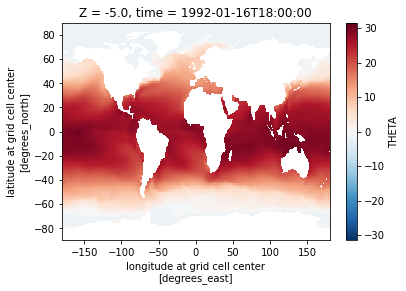

In [125]:
# show snapshot of SST
ecco_data_mon_mean_ll.THETA.isel(Z=0,time=0).plot()

In [133]:
# q is ocean heat content
q_ll = ecco_data_mon_mean_ll.THETA * ocean_cp * rho_ll * vol_ll
q_ll

,Array,Chunk
Bytes,32.35 GB,103.68 MB
Shape,"(312, 50, 360, 720)","(1, 50, 360, 720)"
Count,4057 Tasks,312 Chunks
Type,float64,numpy.ndarray


In [135]:
qs_ll = q_ll.sum(axis=[1,2,3]).compute()

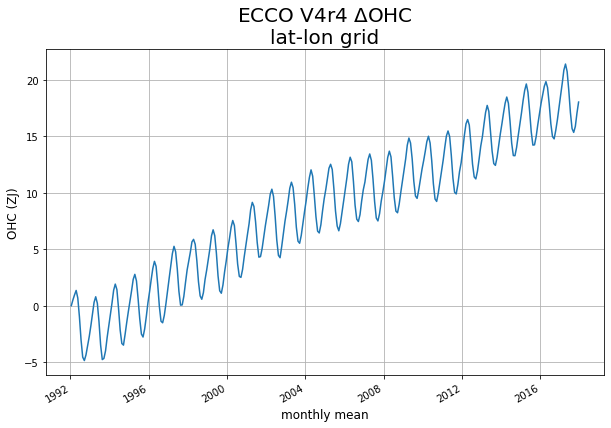

In [190]:
# plot q anomaly
fig = plt.figure(figsize=[10,6]);
qs_ll_all = ((qs_ll-qs_ll[0]) / 1e22)
qs_ll_all.plot()
plt.grid()
plt.title('ECCO V4r4 $\Delta$OHC\nlat-lon grid', fontsize=20);
plt.ylabel('OHC (ZJ)', fontsize=12);
plt.xlabel('monthly mean', fontsize=12);

## Remove the monthly climatology

In [205]:
# Calculate monthly climatology cycle
q_ss_ll = qs_ll.groupby('time.month').mean();

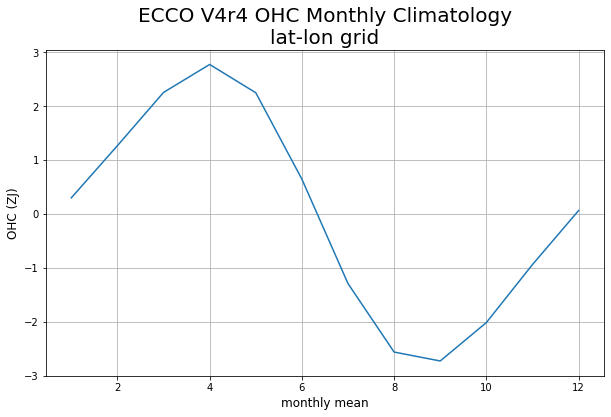

In [206]:
# plot q anomaly
fig = plt.figure(figsize=[10,6]);
((q_ss_ll - q_ss_ll.mean())/1e22).plot()
plt.grid()
plt.title('ECCO V4r4 OHC Monthly Climatology\nlat-lon grid', fontsize=20);
plt.ylabel('OHC (ZJ)', fontsize=12);
plt.xlabel('monthly mean', fontsize=12);

In [142]:
# remove seasonal cycle
qs_anom_ll = qs_ll.groupby('time.month') - q_ss_ll

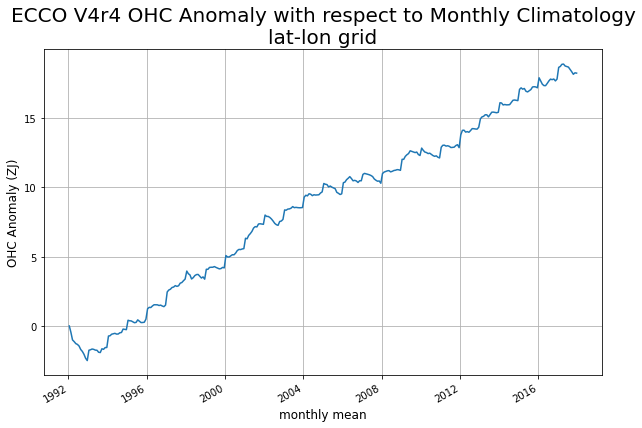

In [207]:
# plot q anomaly
fig = plt.figure(figsize=[10,6]);
((qs_anom_ll -qs_anom_ll[0]) / 1e22).plot()
plt.grid()
plt.title('ECCO V4r4 OHC Anomaly with respect to Monthly Climatology\nlat-lon grid',fontsize=20);
plt.ylabel('OHC Anomaly (ZJ)', fontsize=12);
plt.xlabel('monthly mean', fontsize=12);

# Compare OHC from native grid files vs lat-lon grid files

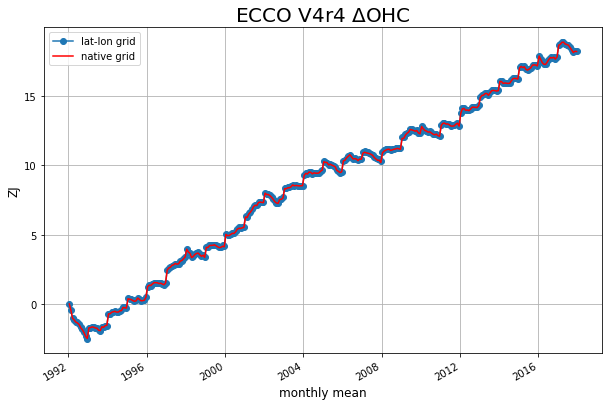

In [201]:
fig = plt.figure(figsize=[10,6]);

((qs_anom_ll-qs_anom_ll[0])/1e22).plot(marker='o')
((qs_anom-qs_anom[0])/1e22).plot(color='r')

plt.grid()
plt.title('ECCO V4r4 $\Delta$OHC', fontsize=20);
plt.ylabel('ZJ', fontsize=12);
plt.xlabel('monthly mean', fontsize=12);
plt.legend(['lat-lon grid','native grid']);

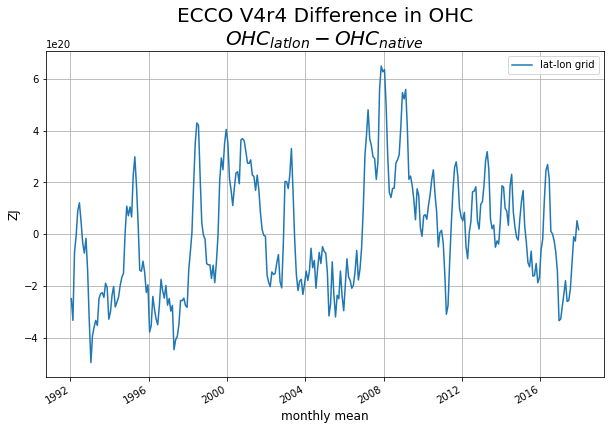

In [194]:
fig = plt.figure(figsize=[10,6]);

((qs_anom_ll - qs_anom)).plot()

plt.grid()
plt.title('ECCO V4r4 Difference in OHC\n$OHC_{latlon} - OHC_{native}$', fontsize=20);
plt.ylabel('ZJ', fontsize=12);
plt.xlabel('monthly mean', fontsize=12);

plt.legend(['lat-lon grid','native grid'])

## Proportional difference in OHC calculated using lat-lon vs. native grid files

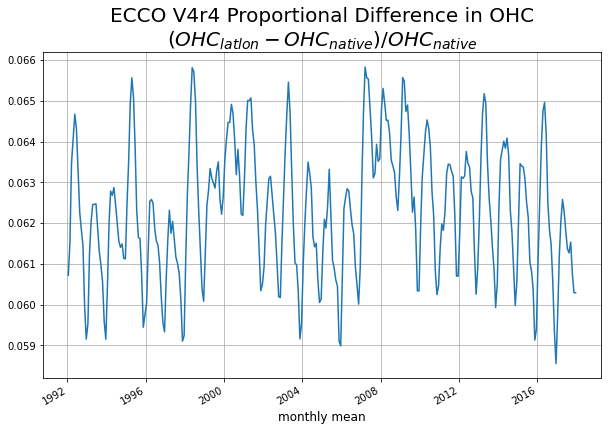

In [186]:
fig = plt.figure(figsize=[10,6]);

(100*((qs_ll - qs)/qs)).plot()
plt.grid()
plt.title('ECCO V4r4 Proportional Difference in OHC\n$(OHC_{latlon} - OHC_{native})/ OHC_{native}$', fontsize=20);
plt.xlabel('monthly mean', fontsize=12);

Difference is < 0.1%

# Save to Disk

In [133]:
qs_ZJ_zero_ref.name = 'ECCO_OHC_ZJ'
qs_ZJ_zero_ref.attrs['units'] = 'zJ'
qs_ZJ_zero_ref.attrs['long_name'] = 'ECCO V4r4 Monthly-Averaged Global Ocean Heat Content Change'

qs_ZJ_zero_ref_anom.name = 'ECCO_OHC_ANOM_WRT_CLIM_ZJ'
qs_ZJ_zero_ref_anom.attrs['units'] = 'zJ'
qs_ZJ_zero_ref_anom.attrs['long_name'] = 'ECCO V4r4 Monthly-Averaged Global Ocean Heat Content Change with respect to Monthly Climatology'

qs_ZJ_700m_zero_ref.name = 'ECCO_OHC_0_700m_ZJ'
qs_ZJ_700m_zero_ref.attrs['units'] = 'zJ'
qs_ZJ_700m_zero_ref.attrs['long_name'] = 'ECCO V4r4 Monthly-Averaged Global Ocean 0-700m Heat Content Change'

qs_ZJ_700m_zero_ref_anom.name = 'ECCO_OHC_0_700m_ANOM_WRT_CLIM_ZJ'
qs_ZJ_700m_zero_ref_anom.attrs['units'] = 'zJ'
qs_ZJ_700m_zero_ref_anom.attrs['long_name'] = 'ECCO V4r4 Monthly-Averaged Global Ocean 0-700m Heat Content Change with respect to Monthly Climatology'

qs_ZJ_2000m_zero_ref.name = 'ECCO_OHC_0_2000m_ZJ'
qs_ZJ_2000m_zero_ref.attrs['units'] = 'zJ'
qs_ZJ_2000m_zero_ref.attrs['long_name'] = 'ECCO V4r4 Monthly-Averaged Global Ocean 0-2000m Heat Content Change'

qs_ZJ_2000m_zero_ref_anom.name = 'ECCO_OHC_0_2000m_ANOM_WRT_CLIM_ZJ'
qs_ZJ_2000m_zero_ref_anom.attrs['units'] = 'zJ'
qs_ZJ_2000m_zero_ref_anom.attrs['long_name'] = 'ECCO V4r4 Monthly-Averaged Global Ocean 0-2000m Heat Content Change with respect to Monthly Climatology'


ECCO_OHC = xr.merge([qs_ZJ_zero_ref, qs_ZJ_zero_ref_anom,qs_ZJ_700m_zero_ref, qs_ZJ_700m_zero_ref_anom,\
                    qs_ZJ_2000m_zero_ref, qs_ZJ_2000m_zero_ref_anom])

attrs = ['acknowledgement','program','author','creator_email']
for attr in attrs:
    ECCO_OHC.attrs[attr] = ecco_grid.attrs[attr]
    
ECCO_OHC.attrs['title'] = "ECCO V4r4 Global Ocean Heat Content"
ECCO_OHC.attrs['summary'] = 'This dataset provides monthly-averaged global ocean heat content from the ECCO Version 4 Release 4 (V4r4) ocean and sea-ice state estimate. Parameters include areas and lengths of grid cell sides; horizontal and vertical coordinates of grid cell centers and corners; grid rotation angles; and global domain geometry including bathymetry and land/ocean masks. Estimating the Circulation and Climate of the Ocean (ECCO) state estimates are dynamically and kinematically-consistent reconstructions of the three-dimensional, time-evolving ocean, sea-ice, and surface atmospheric states. ECCO V4r4 is a free-running solution of a global, nominally 1-degree configuration of the MIT general circulation model (MITgcm) that has been fit to observations in a least-squares sense. Observational data constraints used in V4r4 include sea surface height (SSH) from satellite altimeters [ERS-1/2, TOPEX/Poseidon, GFO, ENVISAT, Jason-1,2,3, CryoSat-2, and SARAL/AltiKa]; sea surface temperature (SST) from satellite radiometers [AVHRR], sea surface salinity (SSS) from the Aquarius satellite radiometer/scatterometer, ocean bottom pressure (OBP) from the GRACE satellite gravimeter; sea ice concentration from satellite radiometers [SSM/I and SSMIS], and in-situ ocean temperature and salinity measured with conductivity-temperature-depth (CTD) sensors and expendable bathythermographs (XBTs) from several programs [e.g., WOCE, GO-SHIP, Argo, and others] and platforms [e.g., research vessels, gliders, moorings, ice-tethered profilers, and instrumented pinnipeds]. V4r4 covers the period 1992-01-01T12:00:00 to 2018-01-01T00:00:00.'
ECCO_OHC.to_netcdf('/home/ifenty/tmp/OHC/ECCO_V4r4_GLOBAL_OCEAN_HEAT_CONTENT_MONTHLY.nc')

In [331]:
qs_lat_ZJ_2000m_zero_ref

<xarray.DataArray (lat_i: 9, time: 312)>
array([[ 0.        ,  3.3533107 ,  2.0156177 , ..., 21.38596974,
        26.06306421, 24.49625211],
       [ 0.        , -0.185896  ,  5.20067224, ..., 36.02436503,
        36.02084006, 34.79865521],
       [ 0.        , -2.41535585, -1.81201617, ..., 27.29036521,
        28.02131287, 26.90985161],
       ...,
       [ 0.        ,  1.83350726,  1.24382681, ..., 13.98346845,
        13.43001659, 14.58143839],
       [ 0.        , -0.5145529 , -0.89553155, ...,  4.93099144,
         3.86804301,  3.06793831],
       [ 0.        , -0.05014245, -0.08997734, ...,  3.31234428,
         3.26803388,  3.21988934]])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Dimensions without coordinates: lat_i

In [333]:
qs_lat_ZJ_zero_ref.name = 'ECCO_OHC_ZJ'
qs_lat_ZJ_zero_ref.attrs['units'] = 'zJ'
qs_lat_ZJ_zero_ref.attrs['long_name'] = 'ECCO V4r4 Monthly-Averaged Global Ocean Heat Content Change'

qs_lat_ZJ_700m_zero_ref.name = 'ECCO_OHC_0_700m_ZJ'
qs_lat_ZJ_700m_zero_ref.attrs['units'] = 'zJ'
qs_lat_ZJ_700m_zero_ref.attrs['long_name'] = 'ECCO V4r4 Monthly-Averaged Global Ocean 0-700m Heat Content Change'

qs_lat_ZJ_2000m_zero_ref.name = 'ECCO_OHC_0_2000m_ZJ'
qs_lat_ZJ_2000m_zero_ref.attrs['units'] = 'zJ'
qs_lat_ZJ_2000m_zero_ref.attrs['long_name'] = 'ECCO V4r4 Monthly-Averaged Global Ocean 0-2000m Heat Content Change'


ECCO_LAT_OHC = xr.merge([qs_lat_ZJ_zero_ref,qs_lat_ZJ_700m_zero_ref, qs_lat_ZJ_2000m_zero_ref])

#%%
attrs = ['acknowledgement','program','author','creator_email']
for attr in attrs:
    ECCO_LAT_OHC.attrs[attr] = ecco_grid.attrs[attr]
    
ECCO_LAT_OHC.attrs['title'] = "ECCO V4r4 Global Ocean Heat Content"
ECCO_LAT_OHC.attrs['summary'] = 'This dataset provides monthly-averaged global ocean heat content from the ECCO Version 4 Release 4 (V4r4) ocean and sea-ice state estimate. Parameters include areas and lengths of grid cell sides; horizontal and vertical coordinates of grid cell centers and corners; grid rotation angles; and global domain geometry including bathymetry and land/ocean masks. Estimating the Circulation and Climate of the Ocean (ECCO) state estimates are dynamically and kinematically-consistent reconstructions of the three-dimensional, time-evolving ocean, sea-ice, and surface atmospheric states. ECCO V4r4 is a free-running solution of a global, nominally 1-degree configuration of the MIT general circulation model (MITgcm) that has been fit to observations in a least-squares sense. Observational data constraints used in V4r4 include sea surface height (SSH) from satellite altimeters [ERS-1/2, TOPEX/Poseidon, GFO, ENVISAT, Jason-1,2,3, CryoSat-2, and SARAL/AltiKa]; sea surface temperature (SST) from satellite radiometers [AVHRR], sea surface salinity (SSS) from the Aquarius satellite radiometer/scatterometer, ocean bottom pressure (OBP) from the GRACE satellite gravimeter; sea ice concentration from satellite radiometers [SSM/I and SSMIS], and in-situ ocean temperature and salinity measured with conductivity-temperature-depth (CTD) sensors and expendable bathythermographs (XBTs) from several programs [e.g., WOCE, GO-SHIP, Argo, and others] and platforms [e.g., research vessels, gliders, moorings, ice-tethered profilers, and instrumented pinnipeds]. V4r4 covers the period 1992-01-01T12:00:00 to 2018-01-01T00:00:00.'
ECCO_LAT_OHC.to_netcdf('/home/ifenty/tmp/OHC/ECCO_V4r4_GLOBAL_OCEAN_HEAT_CONTENT_MONTHLY_BY_10DEG_LAT.nc')

In [134]:
# Make annual average
ECCO_OHC_annual = ECCO_OHC.groupby('time.year').mean()
ECCO_OHC_annual = ECCO_OHC_annual.assign_coords({'year': ECCO_OHC_annual.year.values + 0.5})

attrs = ['acknowledgement','program','author','creator_email']
for attr in attrs:
    ECCO_OHC_annual.attrs[attr] = ecco_grid.attrs[attr]
    
ECCO_OHC_annual.attrs['title'] = "ECCO V4r4 Global Ocean Heat Content"
ECCO_OHC_annual.attrs['summary'] = 'This dataset provides annual-averaged global ocean heat content from the ECCO Version 4 Release 4 (V4r4) ocean and sea-ice state estimate. Parameters include areas and lengths of grid cell sides; horizontal and vertical coordinates of grid cell centers and corners; grid rotation angles; and global domain geometry including bathymetry and land/ocean masks. Estimating the Circulation and Climate of the Ocean (ECCO) state estimates are dynamically and kinematically-consistent reconstructions of the three-dimensional, time-evolving ocean, sea-ice, and surface atmospheric states. ECCO V4r4 is a free-running solution of a global, nominally 1-degree configuration of the MIT general circulation model (MITgcm) that has been fit to observations in a least-squares sense. Observational data constraints used in V4r4 include sea surface height (SSH) from satellite altimeters [ERS-1/2, TOPEX/Poseidon, GFO, ENVISAT, Jason-1,2,3, CryoSat-2, and SARAL/AltiKa]; sea surface temperature (SST) from satellite radiometers [AVHRR], sea surface salinity (SSS) from the Aquarius satellite radiometer/scatterometer, ocean bottom pressure (OBP) from the GRACE satellite gravimeter; sea ice concentration from satellite radiometers [SSM/I and SSMIS], and in-situ ocean temperature and salinity measured with conductivity-temperature-depth (CTD) sensors and expendable bathythermographs (XBTs) from several programs [e.g., WOCE, GO-SHIP, Argo, and others] and platforms [e.g., research vessels, gliders, moorings, ice-tethered profilers, and instrumented pinnipeds]. V4r4 covers the period 1992-01-01T12:00:00 to 2018-01-01T00:00:00.'
ECCO_OHC_annual.to_netcdf('/home/ifenty/tmp/OHC/ECCO_V4r4_GLOBAL_OCEAN_HEAT_CONTENT_ANNUAL.nc')

In [336]:
# Make annual average
ECCO_LAT_OHC_annual = ECCO_LAT_OHC.groupby('time.year').mean()
ECCO_LAT_OHC_annual = ECCO_LAT_OHC_annual.assign_coords({'year': ECCO_OHC_annual.year.values + 0.5})

attrs = ['acknowledgement','program','author','creator_email']
for attr in attrs:
    ECCO_LAT_OHC_annual.attrs[attr] = ecco_grid.attrs[attr]
    
ECCO_LAT_OHC_annual.attrs['title'] = "ECCO V4r4 Global Ocean Heat Content"
ECCO_LAT_OHC_annual.attrs['summary'] = 'This dataset provides annual-averaged global ocean heat content from the ECCO Version 4 Release 4 (V4r4) ocean and sea-ice state estimate. Parameters include areas and lengths of grid cell sides; horizontal and vertical coordinates of grid cell centers and corners; grid rotation angles; and global domain geometry including bathymetry and land/ocean masks. Estimating the Circulation and Climate of the Ocean (ECCO) state estimates are dynamically and kinematically-consistent reconstructions of the three-dimensional, time-evolving ocean, sea-ice, and surface atmospheric states. ECCO V4r4 is a free-running solution of a global, nominally 1-degree configuration of the MIT general circulation model (MITgcm) that has been fit to observations in a least-squares sense. Observational data constraints used in V4r4 include sea surface height (SSH) from satellite altimeters [ERS-1/2, TOPEX/Poseidon, GFO, ENVISAT, Jason-1,2,3, CryoSat-2, and SARAL/AltiKa]; sea surface temperature (SST) from satellite radiometers [AVHRR], sea surface salinity (SSS) from the Aquarius satellite radiometer/scatterometer, ocean bottom pressure (OBP) from the GRACE satellite gravimeter; sea ice concentration from satellite radiometers [SSM/I and SSMIS], and in-situ ocean temperature and salinity measured with conductivity-temperature-depth (CTD) sensors and expendable bathythermographs (XBTs) from several programs [e.g., WOCE, GO-SHIP, Argo, and others] and platforms [e.g., research vessels, gliders, moorings, ice-tethered profilers, and instrumented pinnipeds]. V4r4 covers the period 1992-01-01T12:00:00 to 2018-01-01T00:00:00.'
ECCO_LAT_OHC_annual.to_netcdf('/home/ifenty/tmp/OHC/ECCO_V4r4_GLOBAL_OCEAN_HEAT_CONTENT_ANNUAL_BY_10DEG_LAT.nc')

In [438]:
qs_ZJ_zero_ref_dict = dict()
qs_ZJ_zero_ref_anom_dict = dict()

for ti, t in enumerate(qs_ZJ_zero_ref.time):
    ts = str(t.values)[0:19]
    ts = ts.replace(":","")
    qs_ZJ_zero_ref_dict[ts] = float(qs_ZJ_zero_ref[ti].values)
    qs_ZJ_zero_ref_anom_dict[ts] = float(qs_ZJ_zero_ref_anom[ti].values)


In [439]:
fname = '/home/ifenty/tmp/OHC/ECCO_V4r4_OHC_ZJ_YYYY-MM-DDTHHMMSS.json'
with open(fname, "w") as outfile:  
    json.dump(qs_ZJ_zero_ref_dict, outfile, indent=4) 
    
fname = '/home/ifenty/tmp/OHC/ECCO_V4r4_OHC_ZJ_YYYY-MM-DDTHHMMSS_anom.json'
with open(fname, "w") as outfile:  
    json.dump(qs_ZJ_zero_ref_dict_anom, outfile, indent=4) 

In [440]:
qs_ZJ_zero_ref_dict = dict()
qs_ZJ_zero_ref_anom_dict = dict()

for ti, t in enumerate(qs_ZJ_zero_ref.time):
    ts = str(t.values)[0:7]
    ts = ts.replace(":","")
    qs_ZJ_zero_ref_dict[ts] = float(qs_ZJ_zero_ref[ti].values)
    qs_ZJ_zero_ref_anom_dict[ts] = float(qs_ZJ_zero_ref_anom[ti].values)


In [441]:
fname = '/home/ifenty/tmp/OHC/ECCO_V4r4_OHC_ZJ_YYYY-MM.json'
with open(fname, "w") as outfile:  
    json.dump(qs_ZJ_zero_ref_dict, outfile, indent=4) 
    
fname = '/home/ifenty/tmp/OHC/ECCO_V4r4_OHC_ZJ_YYYY-MM_anom.json'
with open(fname, "w") as outfile:  
    json.dump(qs_ZJ_zero_ref_dict_anom, outfile, indent=4) 